### [Jump to an interactive visualization of the domain segmentation for a randomly selected UniProt ID](#tps_random_id_segmentation)

In [1]:
# corresponding AlphaFold2 structures are supposed to be stored in the folder ../data/alphafold_structs
# note: regarding the names of domains, here instead of beta-2 and delta in the final publication we use delta and epsilon (wip names)

In [2]:
import os
os.chdir("..")
from utils.structural_algorithms import *
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np
from uuid import uuid4
from collections import defaultdict
from multiprocessing import Pool
import pickle
import pandas as pd
from shutil import copyfile
import time
import py3Dmol
from Bio import PDB
from random import choice

In [3]:
tps_df = pd.read_csv("data/TPS-Nov19_2023_verified_all_reactions_with_neg_with_folds.csv")
tps_ids = set(tps_df["Uniprot ID"].values)
tps_ids_pos = set(
    tps_df.loc[tps_df["Type (mono, sesq, di, …)"] != "Unknown", "Uniprot ID"].values
)

In [4]:
tps_df[tps_df['Uniprot ID'].map(lambda x: 'SRR18681978' in x)]

,Uniprot ID,Name,Amino acid sequence,Species,"Kingdom (plant, fungi, bacteria)","Type (mono, sesq, di, …)",Class (I or II),Substrate (including stereochemistry),Substrate ChEBI ID,Cofactors,...,Reaction,Notes,Publication,OK row flag,SMILES of substrate,SMILES_substrate_canonical_no_stereo,SMILES_product_canonical_no_stereo,is_substrate_predicted,stratified_phylogeny_based_split_with_minor_products,stratified_phylogeny_based_split_with_minor_products_ignore_in_eval
102,SRA.SRR18681978 (AgTS-1),Alloaromadendrene synthase,MSQFVEVPIKSLVLQHPLRYAHSAFDSAKLQISSVSMSLKDKLHNH...,Agelas clathrodes,Animalia,sesq,Class I,"(2E,6E)-FPP",175763,NaN,...,NaN,NaN,https://www.pnas.org/doi/10.1073/pnas.2220934120,1,CC(C)=CCC\C(C)=C\CC\C(C)=C\COP([O-])(=O)OP([O-...,CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([...,CC1CCC2C1C1C(CCC2=C)C1(C)C,0,fold_4,NaN
103,SRA.SRR18681978 (AgTS-1),Alloaromadendrene synthase,MSQFVEVPIKSLVLQHPLRYAHSAFDSAKLQISSVSMSLKDKLHNH...,Agelas clathrodes,Animalia,mono,Class I,(2E)-GPP,58057,NaN,...,NaN,NaN,https://www.pnas.org/doi/10.1073/pnas.22209341200,1,CC(C)=CCC\C(C)=C\COP([O-])(=O)OP([O-])([O-])=O,CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O,CC(C)=CCCC(=C)C=C,0,fold_4,NaN
104,SRA.SRR18681978 (AgTS-1),Alloaromadendrene synthase,MSQFVEVPIKSLVLQHPLRYAHSAFDSAKLQISSVSMSLKDKLHNH...,Agelas clathrodes,Animalia,mono,Class I,(2E)-GPP,58057,NaN,...,NaN,NaN,https://www.pnas.org/doi/10.1073/pnas.22209341200,1,CC(C)=CCC\C(C)=C\COP([O-])(=O)OP([O-])([O-])=O,CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O,CC(C)=CCC=C(C)C=C,0,fold_4,NaN


In [5]:
os.chdir("data/alphafold_structs/")

In [7]:
#run for the first time, then reload the notebook for multiprocessing inside Pymol to work efficiently (empirically observed behaviour)
pdb_files_raw = [
        filepath
        for filepath in Path(".").glob("*.pdb")
    ]
# substituting ids which Pymol cannot handle
pdb_files = []
filepath_2_corrected_filepath = {}
for filepath in pdb_files_raw:
    filepath_str = str(filepath)
    if '(' in filepath_str or ')' in filepath_str or len(filepath_str.split()) > 1:
        filepath_2_corrected_filepath[filepath] = Path("".join(filepath_str.replace("(", "").replace(")", "").split()))
        copyfile(filepath, filepath_2_corrected_filepath[filepath])        
    pdb_files.append(filepath_2_corrected_filepath.get(filepath, filepath))
file_2_all_residues = get_all_residues_per_file(pdb_files, cmd)
with open('../file_2_all_residues.pkl', 'wb') as f:
    pickle.dump(file_2_all_residues, f)

All residues:   0%|          | 0/11943 [00:00<?, ?it/s]

In [6]:
with open("../file_2_all_residues.pkl", "rb") as f:
    file_2_all_residues = pickle.load(f)

In [7]:
blacklist_files = (
    {"1ps1.pdb", "5eat.pdb", "3p5r.pdb", "P48449.pdb"}
    .union({f"{domain}.pdb" for domain in SUPPORTED_DOMAINS})
    .union({f"{domain}_object.pdb" for domain in SUPPORTED_DOMAINS})
)
pdb_files = [
    filepath
    for filepath in Path(".").glob("*.pdb")
    if str(filepath) not in blacklist_files
    and filepath.stem in file_2_all_residues
    and (
        filepath.stem in tps_ids
        or "".join(filepath.stem.replace("(", "").replace(")", "").replace("-", ""))
        in tps_ids
    )
]

In [8]:
domain_2_threshold = {
    "beta": (0.6, 50),
    "delta": (0.6, 50),
    "epsilon": (0.6, 50),
    "gamma": (0.55, 50),
    "alpha": (0.35, 130),
}

# Alpha domain

In [9]:
start_t = time.time()
file_2_tmscore_residues_alpha = get_alignments(pdb_files, "alpha", file_2_all_residues)
print(f'Execution took {time.time() - start_t: .0f} seconds')

Execution took  143 seconds


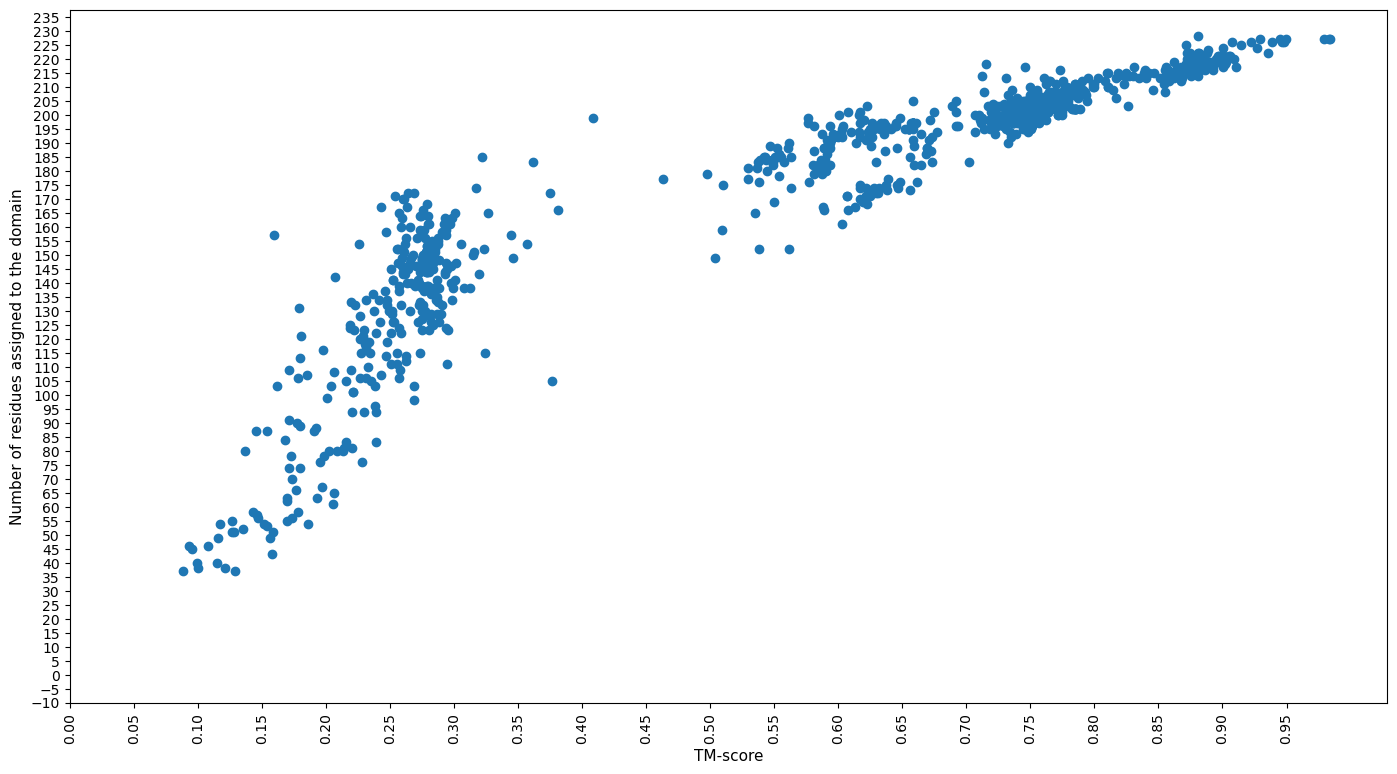

In [10]:
plot_aligned_domains(file_2_tmscore_residues_alpha)

In [11]:
regions_of_possible_alphas = []

for uni_id, detections in file_2_tmscore_residues_alpha.items():
    for i, (tmscore, mapping) in enumerate(detections):
        if tmscore >= domain_2_threshold["alpha"][0]:
            regions_of_possible_alphas.append(
                (
                    uni_id,
                    MappedRegion(
                        module_id=f"{uni_id}_alpha_{i}",
                        domain="alpha",
                        tmscore=tmscore,
                        residues_mapping=mapping,
                    ),
                )
            )

with open("final_regions_alphas_tm_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_alphas, f)

In [12]:
len(regions_of_possible_alphas)

1044

## 2nd alpha domain

In [13]:
domain_2_file_2_tmscore_residues = {"alpha": file_2_tmscore_residues_alpha}

file_2_mapped_regions = get_mapped_regions_per_file(
    domain_2_file_2_tmscore_residues, domain_2_threshold
)
file_2_remaining_residues = get_remaining_residues(
    file_2_mapped_regions, file_2_all_residues
)
tmscore_threshold, mapping_size_threshold = domain_2_threshold["alpha"]
file_2_tmscore_residues_2nd_alpha = get_alignments(
    pdb_files,
    "alpha",
    file_2_remaining_residues,
    tmscore_threshold,
    mapping_size_threshold,
)

In [14]:
regions_of_possible_2nd_alphas = []

for uni_id, detections in file_2_tmscore_residues_2nd_alpha.items():
    for i, (tmscore, mapping) in enumerate(detections):
        new_tuple = (
            uni_id,
            MappedRegion(
                module_id=f"{uni_id}_alpha_{i + len(file_2_tmscore_residues_alpha[uni_id])}",
                domain="alpha",
                tmscore=tmscore,
                residues_mapping=mapping,
            ),
        )
        regions_of_possible_alphas.append(new_tuple)
        regions_of_possible_2nd_alphas.append(new_tuple)

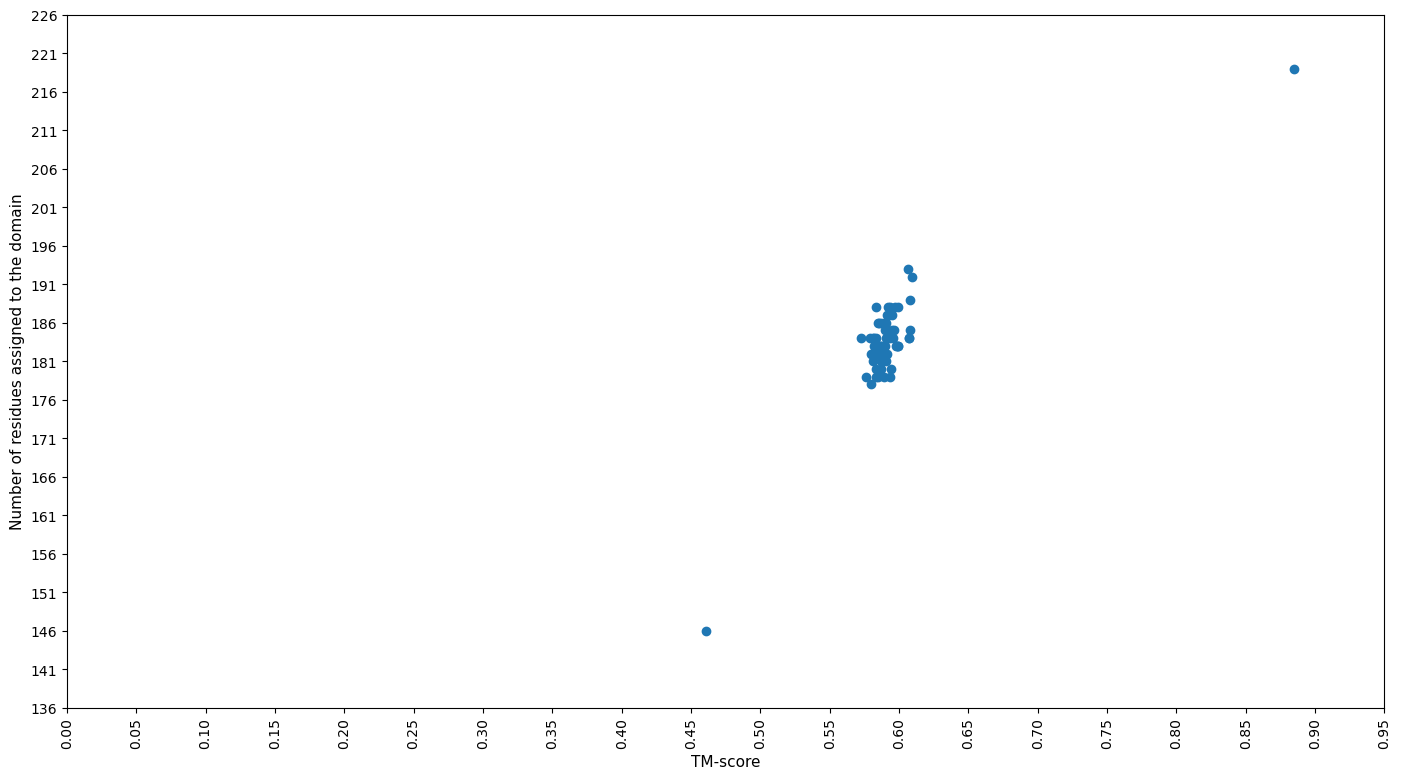

In [15]:
plot_aligned_domains(file_2_tmscore_residues_2nd_alpha)

In [16]:
with open("final_regions_alphas_tm_2nd_alpha_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_2nd_alphas, f)

In [17]:
len(regions_of_possible_2nd_alphas)

63

# Epsilon domain (Delta in publication)

In [18]:
start_t = time.time()
file_2_tmscore_residues_epsilon = get_alignments(pdb_files, "epsilon", file_2_all_residues)
print(f'Execution took {time.time() - start_t: .0f} seconds')

Execution took  159 seconds


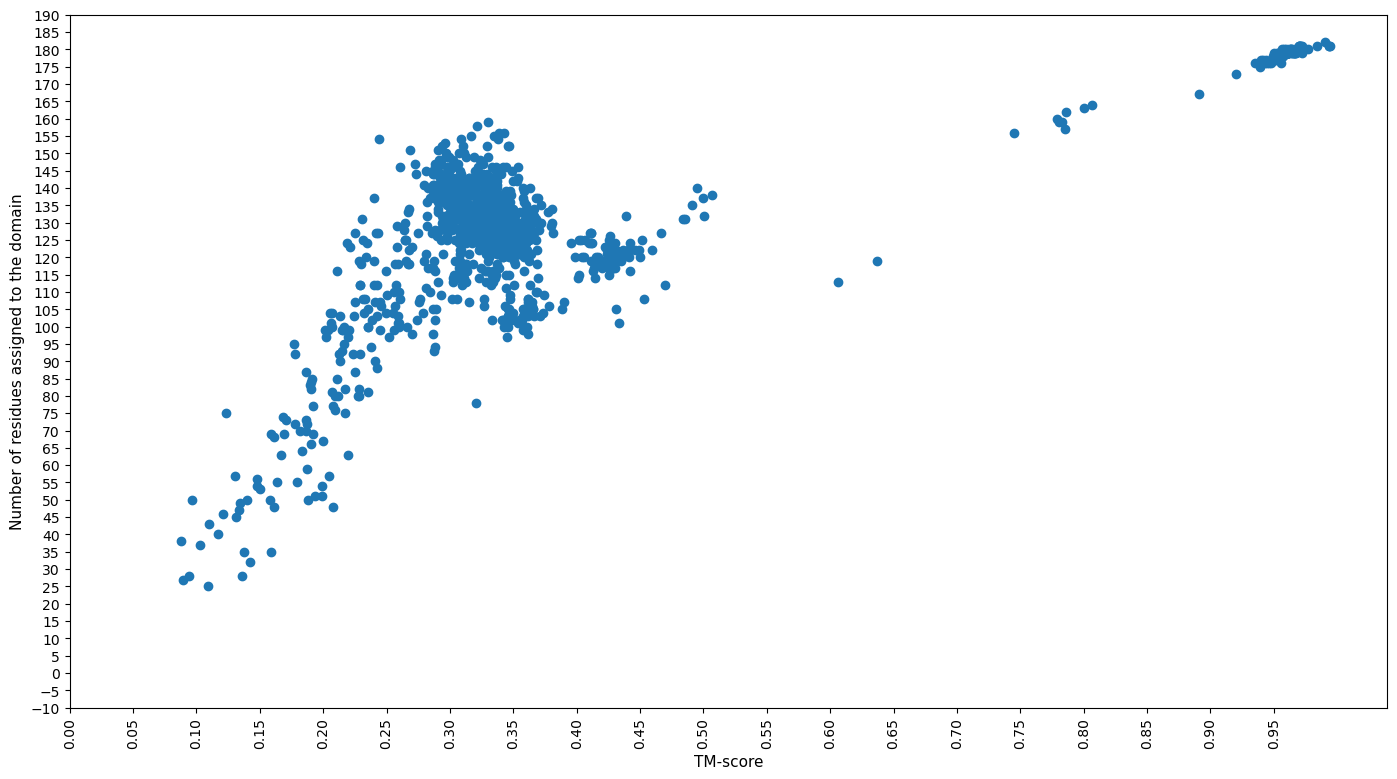

In [19]:
plot_aligned_domains(file_2_tmscore_residues_epsilon)

In [20]:
regions_of_possible_epsilon = []
for uni_id, detections in file_2_tmscore_residues_epsilon.items():
    if uni_id in tps_ids:
        for i, (tmscore, mapping) in enumerate(detections):
            if tmscore >= domain_2_threshold["epsilon"][0]:
                regions_of_possible_epsilon.append(
                    (
                        uni_id,
                        MappedRegion(
                            module_id=f"{uni_id}_epsilon_{i}",
                            domain="epsilon",
                            tmscore=tmscore,
                            residues_mapping=mapping,
                        ),
                    )
                )

with open("regions_of_possible_epsilon_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_epsilon, f)

# Delta domain (beta_2 in publication)


In [21]:
start_t = time.time()
file_2_tmscore_residues_delta = get_alignments(pdb_files, "delta", file_2_all_residues)
print(f'Execution took {time.time() - start_t: .0f} seconds')

Execution took  160 seconds


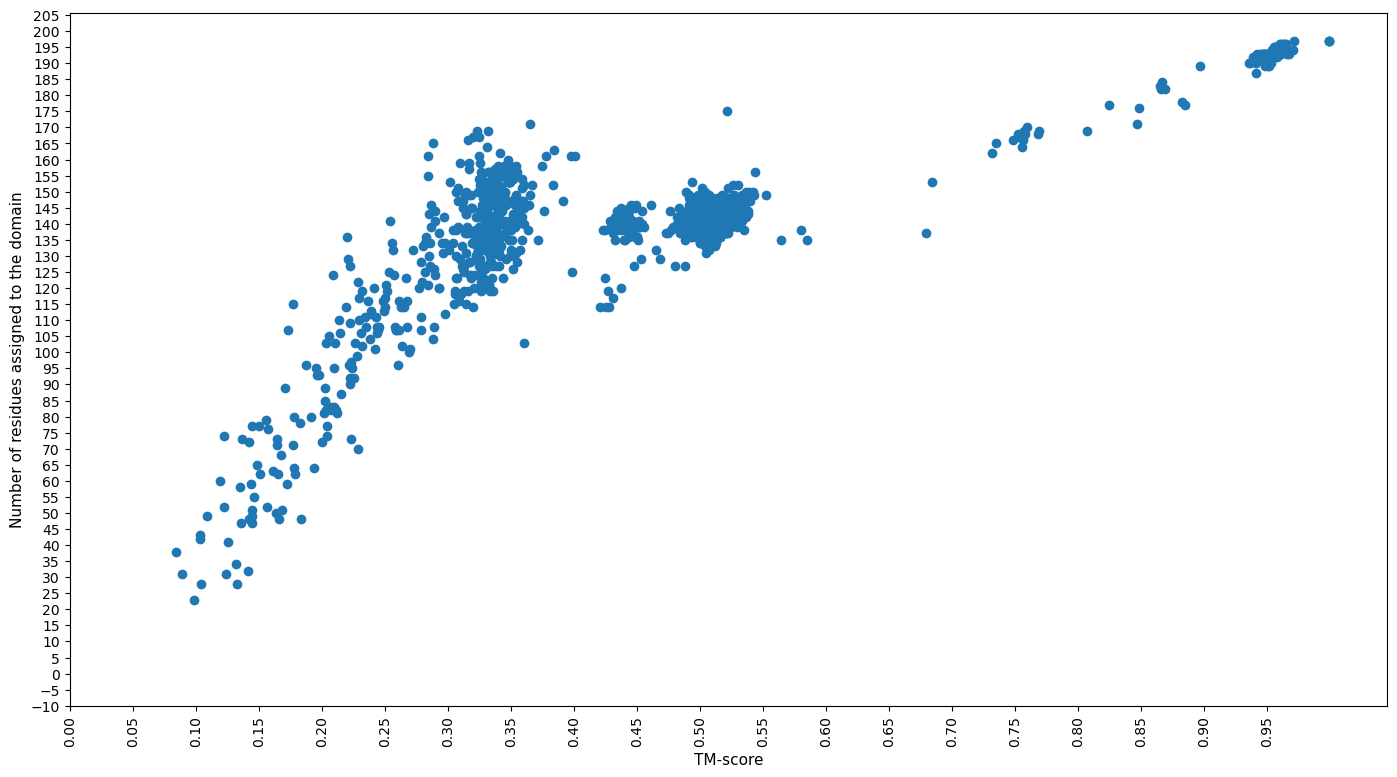

In [22]:
plot_aligned_domains(file_2_tmscore_residues_delta)

In [23]:
regions_of_possible_delta = []

for uni_id, detections in file_2_tmscore_residues_delta.items():
    if uni_id in tps_ids:
        for i, (tmscore, mapping) in enumerate(detections):
            if tmscore >= domain_2_threshold["delta"][0]:
                regions_of_possible_delta.append(
                    (
                        uni_id,
                        MappedRegion(
                            module_id=f"{uni_id}_delta_{i}",
                            domain="delta",
                            tmscore=tmscore,
                            residues_mapping=mapping,
                        ),
                    )
                )

with open("regions_of_possible_delta_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_delta, f)

# Beta domain

In [24]:
start_t = time.time()
file_2_tmscore_residues_beta = get_alignments(pdb_files, "beta", file_2_all_residues)
print(f'Execution took {time.time() - start_t: .0f} seconds')

Execution took  146 seconds


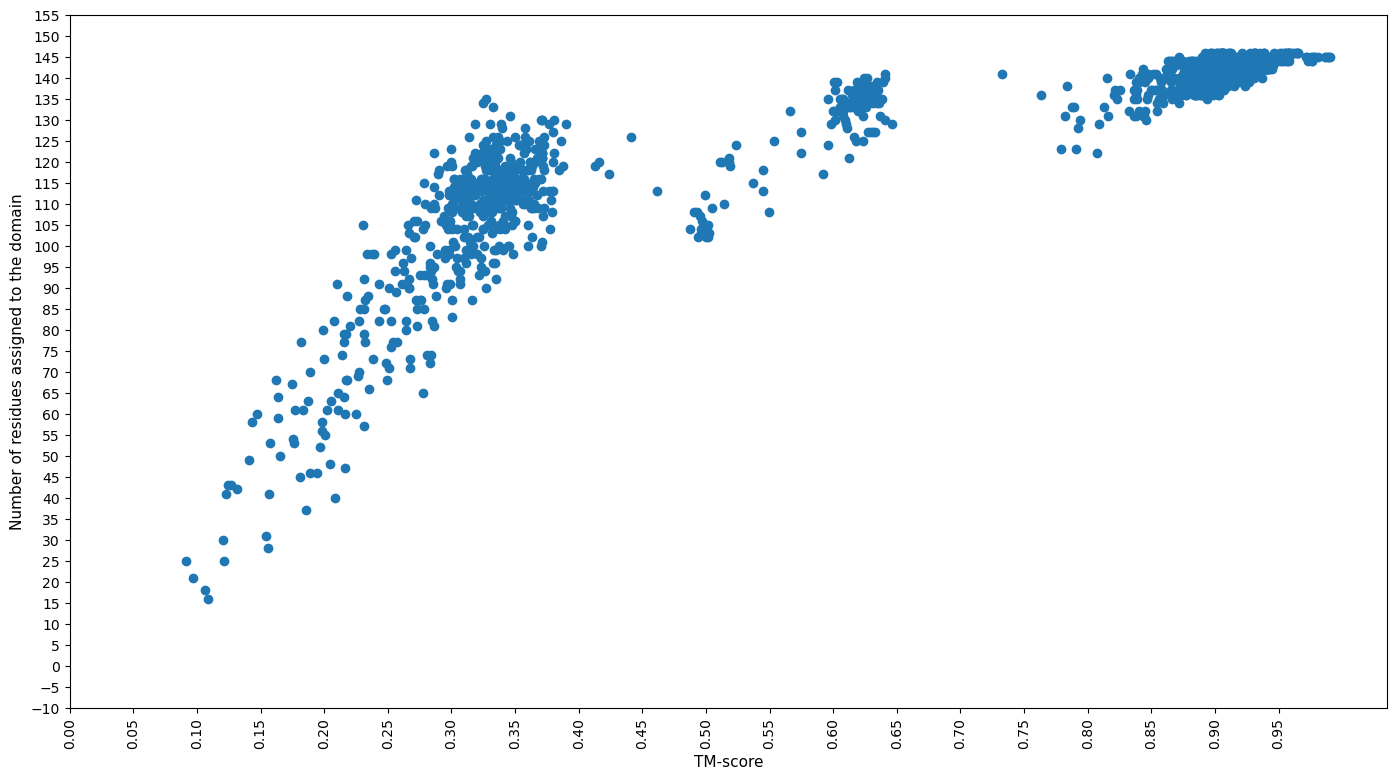

In [25]:
plot_aligned_domains(file_2_tmscore_residues_beta)

In [26]:
regions_of_possible_beta = []

for uni_id, detections in file_2_tmscore_residues_beta.items():
    if uni_id in tps_ids:
        for i, (tmscore, mapping) in enumerate(detections):
            if tmscore >= domain_2_threshold["beta"][0]:
                regions_of_possible_beta.append(
                    (
                        uni_id,
                        MappedRegion(
                            module_id=f"{uni_id}_beta_{i}",
                            domain="beta",
                            tmscore=tmscore,
                            residues_mapping=mapping,
                        ),
                    )
                )

with open("regions_beta_tm_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_beta, f)

# Gamma domain

In [27]:
start_t = time.time()
file_2_tmscore_residues_gamma = get_alignments(pdb_files, "gamma", file_2_all_residues)
print(f'Execution took {time.time() - start_t: .0f} seconds')

Execution took  199 seconds


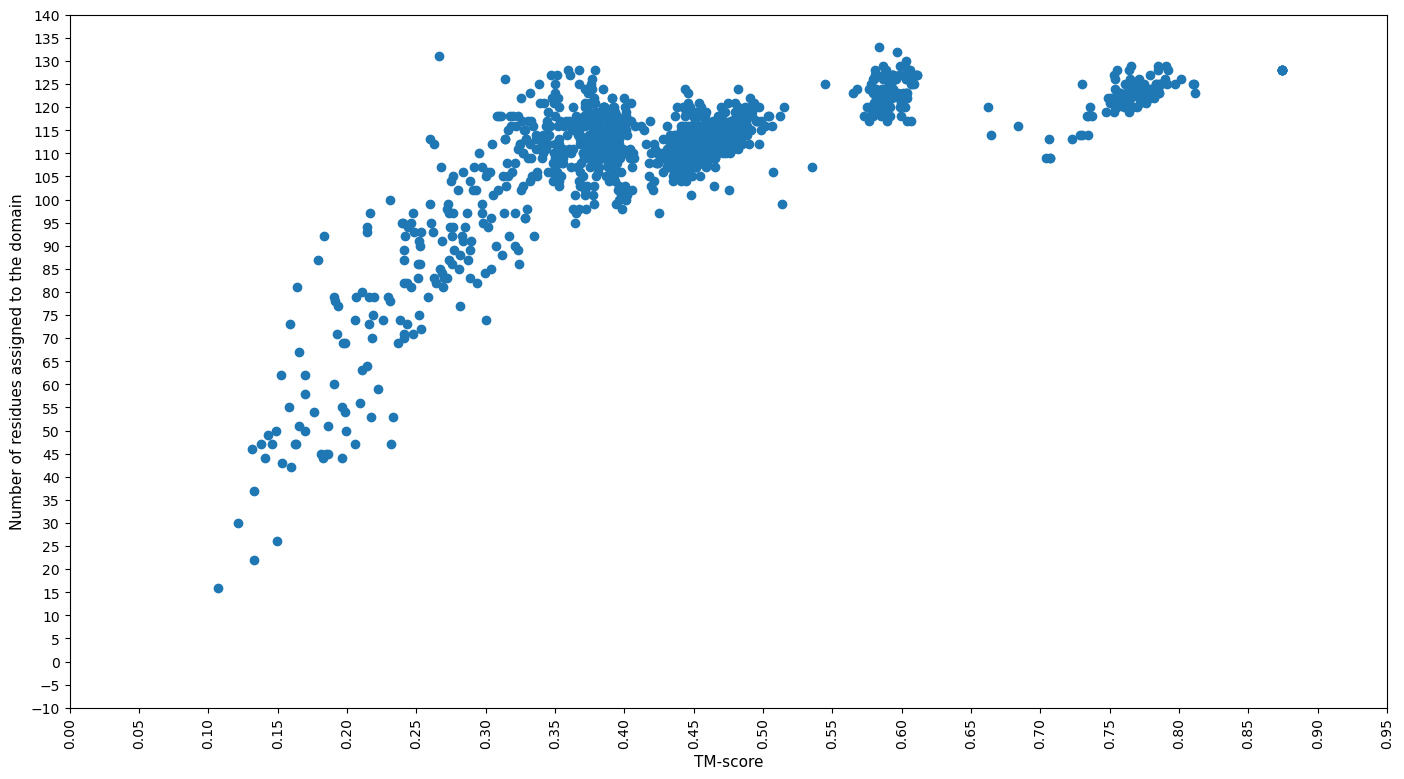

In [28]:
plot_aligned_domains(file_2_tmscore_residues_gamma)

In [29]:
regions_of_possible_gammas = []

for uni_id, detections in file_2_tmscore_residues_gamma.items():
    if uni_id in tps_ids:
        for i, (tmscore, mapping) in enumerate(detections):
            if tmscore >= domain_2_threshold["gamma"][0]:
                regions_of_possible_gammas.append(
                    (
                        uni_id,
                        MappedRegion(
                            module_id=f"{uni_id}_gamma_{i}",
                            domain="gamma",
                            tmscore=tmscore,
                            residues_mapping=mapping,
                        ),
                    )
                )

with open("regions_gammas_tm_ALL.pkl", "wb") as f:
    pickle.dump(regions_of_possible_gammas, f)

# Regions/domains per file

In [30]:
with open("final_regions_alphas_tm_ALL.pkl", "rb") as f:
    regions_of_possible_alphas = pickle.load(f)
with open("final_regions_alphas_tm_2nd_alpha_ALL.pkl", "rb") as f:
    regions_of_possible_alphas += pickle.load(f)
with open("regions_of_possible_epsilon_ALL.pkl", "rb") as f:
    regions_of_possible_epsilon = pickle.load(f)
with open("regions_of_possible_delta_ALL.pkl", "rb") as f:
    regions_of_possible_delta = pickle.load(f)
with open("regions_beta_tm_ALL.pkl", "rb") as f:
    regions_of_possible_beta = pickle.load(f)
with open("regions_gammas_tm_ALL.pkl", "rb") as f:
    regions_of_possible_gammas = pickle.load(f)

In [31]:
######### utils ##########
def is_similar_to_known_region(
    region_known: str, region_new: str, threshold_recall_threshold: float = 0.5
) -> bool:
    """Function checking overlaps of two regions"""
    mapped_residues_known = set(region_known.residues_mapping.keys())
    mapped_residues_new = set(region_new.residues_mapping.keys())
    return (
        len(mapped_residues_new.intersection(mapped_residues_known))
        / len(mapped_residues_new)
        >= threshold_recall_threshold
    )


def is_similar_to_anything_known(
    region_new: str, filename_2_known_regions: dict[str, list[MappedRegion]], threshold_recall_threshold: float = 0.5
) -> bool:
    """Function checks if `region_new` overlaps with any of known regions"""
    filename_new, mapped_region_new = region_new
    for region_known in filename_2_known_regions[filename_new]:
        if is_similar_to_known_region(
            region_known, mapped_region_new, threshold_recall_threshold
        ):
            return True
    return False


########################
# remember alpha domains
filename_2_known_regions = defaultdict(list)

for filename, region in regions_of_possible_alphas:
    filename_2_known_regions[filename].append(region)

###########

# filter clashes with already loaded domains
regions_of_possible_epsilon = [
    region
    for region in regions_of_possible_epsilon
    if not is_similar_to_anything_known(region, filename_2_known_regions)
]
# remember epsilon domains
for filename, region in regions_of_possible_epsilon:
    filename_2_known_regions[filename].append(region)

###########
# filter clashes with already loaded domains
regions_of_possible_delta = [
    region
    for region in regions_of_possible_delta
    if not is_similar_to_anything_known(region, filename_2_known_regions)
]
# remember delta domains
for filename, region in regions_of_possible_delta:
    filename_2_known_regions[filename].append(region)

###########
# filter clashes with already loaded domains
regions_of_possible_beta = [
    region
    for region in regions_of_possible_beta
    if not is_similar_to_anything_known(region, filename_2_known_regions)
]
# remember beta domains
for filename, region in regions_of_possible_beta:
    filename_2_known_regions[filename].append(region)

###########
# filter clashes with already loaded domains
regions_of_possible_gammas = [
    region
    for region in regions_of_possible_gammas
    if not is_similar_to_anything_known(region, filename_2_known_regions)
]
# remember gamma domains
for filename, region in regions_of_possible_gammas:
    filename_2_known_regions[filename].append(region)

# Assigning missed secondary structure parts to closest domains


In [32]:
%%time
filename_2_known_regions_completed = get_mapped_regions_with_surroundings_parallel(
    filename_2_known_regions.keys(), file_2_all_residues, filename_2_known_regions
)

CPU times: user 20.6 s, sys: 510 ms, total: 21.1 s
Wall time: 2min 52s


# Get unsegmented parts and iterate over all domain types for best hit


In [33]:
%%time
file_2_remaining_residues = get_remaining_residues(
    filename_2_known_regions_completed, file_2_all_residues
)

CPU times: user 286 ms, sys: 22.6 ms, total: 308 ms
Wall time: 308 ms


In [34]:
def can_there_be_unassigned_domain(
    filename,
    file_2_remaining_residues,
    filename_2_known_regions,
    min_len=90,
    max_allowed_gap=3,
):
    if filename not in filename_2_known_regions:
        return False
    region_types = {reg.domain for reg in filename_2_known_regions[filename]}
    if "alpha" not in region_types:
        return len(file_2_remaining_residues[filename]) > min_len
    else:
        return (
            len(
                find_continuous_segments_longer_than(
                    file_2_remaining_residues[filename],
                    min_secondary_struct_len=min_len,
                    max_allowed_gap=max_allowed_gap,
                )
            )
            > 0
        )


pdb_files_with_poteintial_unsegmented_domains = [
    filename
    for filename in pdb_files
    if can_there_be_unassigned_domain(
        filename.stem,
        file_2_remaining_residues,
        filename_2_known_regions_completed,
        min_len=70,
        max_allowed_gap=5,
    )
]

In [35]:
domain_2_file_2_tmscore_residues = dict()
for domain_type, (
    tmscore_threshold,
    mapping_size_threshold,
) in domain_2_threshold.items():
    domain_2_file_2_tmscore_residues[domain_type] = get_alignments(
        pdb_files_with_poteintial_unsegmented_domains,
        domain_type,
        file_2_remaining_residues,
        tmscore_threshold,
        mapping_size_threshold,
    )

In [36]:
for domain, file_2_tmscore_residues in domain_2_file_2_tmscore_residues.items():
    for uni_id, detections in file_2_tmscore_residues.items():
        if uni_id in tps_ids:
            for tmscore, mapping in detections:
                n_domains_of_type = len(
                    [
                        reg
                        for reg in filename_2_known_regions[filename]
                        if reg.domain == domain
                    ]
                )
                filename_2_known_regions[filename].append(
                    MappedRegion(
                        module_id=f"{uni_id}_{domain}_{n_domains_of_type}",
                        domain=domain,
                        tmscore=tmscore,
                        residues_mapping=mapping,
                    )
                )

# Getting confident residues

In [37]:
def get_confident_af_residues(uniprot_id, confidence_threshold=70):
    parser = PDB.PDBParser()
    structure = parser.get_structure(uniprot_id, f"{uniprot_id}.pdb")

    confident_residues = set()
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.get_bfactor() >= confidence_threshold:
                        confident_residues.add(residue.get_id()[1])
                    break
    return confident_residues


filename_2_known_regions_completed_confident = dict()
for filename, regions in tqdm(filename_2_known_regions_completed.items()):
    conf_residues = get_confident_af_residues(filename)
    new_regions = []
    for mapped_region_init in regions:
        new_residues_mapping = {
            res: res_dom
            for res, res_dom in mapped_region_init.residues_mapping.items()
            if res in conf_residues
        }
        new_regions.append(
            MappedRegion(
                module_id=mapped_region_init.module_id,
                domain=mapped_region_init.domain,
                tmscore=mapped_region_init.tmscore,
                residues_mapping=new_residues_mapping,
            )
        )
    filename_2_known_regions_completed_confident[filename] = new_regions

  0%|          | 0/1177 [00:00<?, ?it/s]

In [38]:
with open("filename_2_known_regions_completed_very_confident_ALL.pkl", "wb") as f:
    pickle.dump(filename_2_known_regions_completed_confident, f)

regions_completed_confident_all = []
regions_completed_confident_alpha = []
regions_completed_confident_beta = []
regions_completed_confident_gamma = []
regions_completed_confident_delta = []
regions_completed_confident_epsilon = []

region_lengths = []
for filename, protein_regions in filename_2_known_regions_completed_confident.items():
    for region in protein_regions:
        region_lengths.append(len(region.residues_mapping))
        regions_completed_confident_all.append(region)
        match region.domain:
            case "alpha":
                regions_completed_confident_alpha.append((filename, region))
            case "beta":
                regions_completed_confident_beta.append((filename, region))
            case "gamma":
                regions_completed_confident_gamma.append((filename, region))
            case "delta":
                regions_completed_confident_delta.append((filename, region))
            case "epsilon":
                regions_completed_confident_epsilon.append((filename, region))


with open("regions_completed_very_confident_all_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_all, f)
with open("regions_completed_very_confident_alpha_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_alpha, f)
with open("regions_completed_very_confident_beta_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_beta, f)
with open("regions_completed_very_confident_gamma_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_gamma, f)
with open("regions_completed_very_confident_delta_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_delta, f)
with open("regions_completed_very_confident_epsilon_ALL.pkl", "wb") as f:
    pickle.dump(regions_completed_confident_epsilon, f)

# Interactive visualization of our domain segmentation for a randomly sampled structure
<a name="tps_random_id_segmentation"/>

In [39]:
from random import choice

uni_id_random = choice(list(filename_2_known_regions_completed_confident.keys()))
regions = filename_2_known_regions_completed_confident[uni_id_random]
colors_map = {}
for region_ in regions:
    mapped_residues = set(region_.residues_mapping.keys())
    if region_.domain == "alpha":
        color = "#FF0000"
    elif region_.domain == "beta":
        color = "#0000FF"
    elif region_.domain == "gamma":
        color = "#FFFF00"
    elif region_.domain == "delta": # beta-2 in publication
        color = "#808080"
    else:
        color = "#FFC0CB" # delta in publication
    for res in mapped_residues:
        colors_map[res] = color
with open(f"{uni_id_random}.pdb",'r') as file:
    af2_struct = file.read()
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=900, height=700)
view.addModel(af2_struct,'pdb')
view.setStyle({'cartoon':{'colorscheme':{'prop':'resi','map':colors_map}}})
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Storing detected domains

In [40]:
for domain_name in ["alpha", "beta", "gamma", "delta", "epsilon"]:
    path = f"../tps_domain_detections_{domain_name}"
    if not os.path.exists(path):
        os.mkdir(path)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [41]:
for filename, protein_regions in tqdm(
    filename_2_known_regions_completed_confident.items()
):
    for region in protein_regions:
        path = f"../tps_domain_detections_{region.domain}"
        mapped_residues = set(region.residues_mapping.keys())
        cmd.delete(filename)
        cmd.load(f"{filename}.pdb")
        cmd.select(
            f"{region.module_id}",
            f"{filename} & resi {compress_selection_list(mapped_residues)}",
        )
        cmd.save(f"{path}/{region.module_id}.pdb", f"{region.module_id}")
        cmd.delete(filename)

  0%|          | 0/1177 [00:00<?, ?it/s]

# Pairwise similarity computation

In [45]:
n_machines = 15
regions_total = len(regions_completed_confident_all)
delta = regions_total**2 / 2 // n_machines + 1
start_i = 0
i = 0
start_prev = 0
split_indices = [0]
for i in range(regions_total):
    for j in range(i + 1, regions_total):
        start_i += 1
    if start_i - start_prev >= delta:
        split_indices.append(i)
        start_prev = start_i
split_indices.append(regions_total)


def print_script(i, split_indices=split_indices):
    print(f"""cd ~/TPS_ML_Discovery/data/alphafold_structs\npython compute_pairwise_similiarities_of_domains.py --start-i {split_indices[i]} --end-i {split_indices[i + 1]} --n-jobs 64 --domain-name all 
    """
    )


for i in range(len(split_indices) - 1):
    print_script(i)

cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 0 --end-i 73 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 73 --end-i 150 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 150 --end-i 230 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 230 --end-i 313 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 313 --end-i 400 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
python compute_pairwise_similiarities_of_domains.py --start-i 400 --end-i 492 --n-jobs 64 --domain-name all 
    
cd ~/TPS_ML_Discovery/data/alphafold_structs
pytho